In [85]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [86]:
def load_credit_data():
     # Fetch german credit dataset 
     statlog_german_credit_data = fetch_ucirepo(id=144) 
     X = statlog_german_credit_data.data.features 
     y = statlog_german_credit_data.data.targets 

     # Rename columns for clarity
     X.columns = ['account_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 
          'savings', 'employment_since', 'installment_rate', 'sex', 'guarantors', 
          'residence_since', 'property', 'age', 'other_plans', 'housing', 
          'num_credits', 'job', 'num_people_maintenance', 'telephone', 'foreign_worker']

     # Rename and regroup categories for readability
     X['account_status'] = X['account_status'].replace({
          'A11': 'overdrawn',
          'A12': 'stable balance',
          'A13': 'stable balance',
          'A14': 'no account'
     })
     X['credit_history'] = X['credit_history'].replace({
          'A30': 'good',
          'A31': 'good',
          'A33': 'bad',
          'A34': 'bad',
          'A32': 'being repaid'
     })
     X['purpose'] = X['purpose'].replace({
          'A40': 'car',
          'A41': 'car',
          'A42': 'domestic equipment',
          'A43': 'domestic equipment',
          'A44': 'domestic equipment',
          'A45': 'others',
          'A46': 'education',
          'A48': 'education',
          'A49': 'business',
          'A410': 'others'
     })
     X['savings'] = X['savings'].replace({
          'A61': 'little',
          'A62': 'moderate',
          'A63': 'moderate',
          'A64': 'rich',
          'A65': 'NA'
     })
     X['employment_since'] = X['employment_since'].replace({
          'A71': 'unemployed',
          'A72': 'recent position',
          'A73': 'recent position',
          'A74': 'long-term position',
          'A75': 'long-term position'
     })
     X['sex'] = X['sex'].replace({
          'A91': 'male',
          'A93': 'male',
          'A94': 'male',
          'A92': 'female',
          'A95': 'female'
     })
     X['housing'] = X['housing'].replace({
          'A151': 'rent',
          'A152': 'own',
          'A153': 'for free'
     })
     X['job'] = X['job'].replace({
          'A171': 'unskilled',
          'A172': 'unskilled',
          'A173': 'skilled',
          'A174': 'skilled'
     })

     # Drop unnecessary attributes
     X = X.drop(['installment_rate', 'residence_since', 'property', 'other_plans', 'telephone', 'foreign_worker', 'guarantors'], axis=1)

     # Map target labels (1 = Good, 2 = Bad) -> (1 = Good, 0 = Bad)
     y = y.replace({1: 1, 2: 0})
     return X, y

In [87]:
X, y = load_credit_data()

C:\Users\lujul\AppData\Local\Temp\ipykernel_1992\2741382294.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['account_status'] = X['account_status'].replace({
C:\Users\lujul\AppData\Local\Temp\ipykernel_1992\2741382294.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['credit_history'] = X['credit_history'].replace({
C:\Users\lujul\AppData\Local\Temp\ipykernel_1992\2741382294.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [88]:
def get_train_test_data(X, y):
    # Transform continuous variables into categorical
    duration_cat = pd.cut(X['duration'], bins=[0, 12, 24, 36, np.inf], labels=['0-12', '13-24', '25-36', '>36']).astype(str)
    X.insert(1, 'duration_cat', duration_cat)
    age_cat = pd.cut(X['age'], bins=[0, 25, 30, 35, 40, 50, np.inf], labels=['0-25', '26-30', '31-35', '36-40', '41-50', '>50']).astype(str)
    X.insert(9, 'age_group', age_cat)
    X = X.drop(['duration', 'age'], axis=1)

    # Ordinal variables encoding
    X['account_status'] = X['account_status'].map({'overdrawn': 1, 'no account': 2, 'stable balance': 3})
    X['credit_history'] = X['credit_history'].map({'bad': 1, 'being repaid': 2, 'good': 3})
    X['savings'] = X['savings'].map({'NA': 1, 'little':2, 'moderate': 3, 'rich': 4})
    X['employment_since'] = X['employment_since'].map({'unemployed': 1, 'recent position': 2, 'long-term position': 3})
    X['job'] = X['job'].map({'unskilled': 1, 'skilled': 2})
    X['duration_cat'] = X['duration_cat'].map({'0-12': 1, '13-24': 2, '25-36': 3, '>36': 4}).astype(int)
    X['age_group'] = X['age_group'].map({'0-25': 1, '26-30': 2, '31-35': 3, '36-40': 4, '41-50': 5, '>50': 6}).astype(int)
    # Binary Encoding for the Sex variable
    label=LabelEncoder()
    X['sex']=label.fit_transform(X['sex'])
    # One-Hot Encoding for non-ordinal variables
    X = pd.get_dummies(X, columns=['purpose', 'housing'], drop_first=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    scaler=MinMaxScaler()
    X_train['credit_amount']=scaler.fit_transform(X_train[['credit_amount']])
    X_test['credit_amount']=scaler.fit_transform(X_test[['credit_amount']])
    return X_train, X_test, y_train, y_test

In [89]:
X_train, X_test, y_train, y_test = get_train_test_data(X, y)

### Baseline models

In [90]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train.values.ravel())
rf_pred = rf.predict(X_test)

In [91]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train.values.ravel())
xgb_pred = xgb.predict(X_test)

In [92]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train.values.ravel())
lr_pred = lr.predict(X_test)

In [93]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train.values.ravel())
dt_pred = dt.predict(X_test)

### Model performance

In [94]:
def get_model_performance(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    # cost matrix (rows = true classes, columns = predicted classes)
    cost_matrix = np.array([[0, 5],  # Cost for Bad (0)
                            [1, 0]]) # Cost for Good (1)
    cost = np.sum(conf_matrix * cost_matrix)
    print("Accuracy:", accuracy)
    print("Balanced accuracy:", balanced_acc)
    print("Confusion Matrix:\n", conf_matrix)
    print("Total Cost of Misclassification:", cost)

In [95]:
for clf in [rf, lr, dt, xgb]:
    y_pred = clf.predict(X_test)
    print(f'==== {clf.__class__.__name__} ====\n')
    get_model_performance(y_test, y_pred)
    print('\n')

==== RandomForestClassifier ====

Accuracy: 0.765
Balanced accuracy: 0.6975468805283642
Confusion Matrix:
 [[ 32  29]
 [ 18 121]]
Total Cost of Misclassification: 163


==== LogisticRegression ====

Accuracy: 0.7
Balanced accuracy: 0.5817903054605496
Confusion Matrix:
 [[ 17  44]
 [ 16 123]]
Total Cost of Misclassification: 236


==== DecisionTreeClassifier ====

Accuracy: 0.71
Balanced accuracy: 0.6763769312418917
Confusion Matrix:
 [[ 36  25]
 [ 33 106]]
Total Cost of Misclassification: 158


==== XGBClassifier ====

Accuracy: 0.795
Balanced accuracy: 0.7421276093878995
Confusion Matrix:
 [[ 37  24]
 [ 17 122]]
Total Cost of Misclassification: 137




In [123]:
def plot_roc_curve(clfs, X_test, y_true):
    plt.figure(figsize=(8, 6))
    for clf in clfs:
        probs = clf.predict_proba(X_test)
        preds = probs[:, 1]
        fpr, tpr, _ = roc_curve(y_true, preds)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label= f'{clf.__class__.__name__} (auc = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.xlim(0, 1)
    plt.ylim(0,1)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC curve', fontsize=16, fontweight="bold")
    plt.legend(fontsize=12)
    #plt.savefig('roc_curve.png', bbox_inches='tight')
    plt.show()


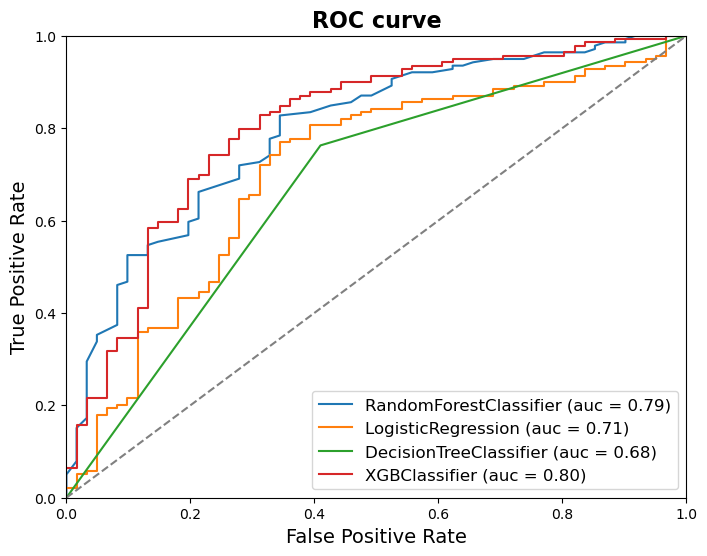

In [97]:
plot_roc_curve([rf, lr, dt, xgb], X_test, y_test)

### Fairness metrics

In [98]:
def classification_metrics(y_true, y_pred):
    """
    Compute classification metrics based on the confusion matrix.

    Args:
        y_true (1d array-like): True labels.
        y_pred (1d array-like): Predicted labels.

    Returns:
        tuple: ACC (Accuracy), TPR (True Positive Rate), FPR (False Positive Rate),
            FNR (False Negative Rate), PPP (Predicted as Positive Proportion)
    """
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    N = TP + FP + FN + TN # Total population
    ACC = (TP + TN) / N # Accuracy
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0 # True positive rate
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0 # False positive rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0 # False negative rate
    PPP = (TP + FP) / N if N > 0 else 0 # Predicted as positive
    
    return ACC, TPR, FPR, FNR, PPP

In [99]:
def classification_metrics_per_group(y_true, y_pred, X_test, sens_att):
    """
    Compute classification metrics for each group defined by a sensitive attribute.

    Args:
        y_true (1d array-like): True labels.
        y_pred (1d array-like): Predicted labels.
        X_test (pd.DataFrame): Test features containing the sensitive attribute.
        sens_att (str): Name of the sensitive attribute column.

    Returns:
        dict: A dictionary where each key is a group value and the value is a dictionary
            of classification metrics (ACC, TPR, FPR, FNR, PPP) for that group.
    """
    groups = X_test[sens_att]
    metrics = {}
    for group in np.unique(groups):
        group_mask = (groups == group)
        ACC, TPR, FPR, FNR, PPP = classification_metrics(y_true[group_mask], y_pred[group_mask])
        metrics[group] = {
            'ACC': ACC,
            'TPR': TPR,
            'FPR': FPR,
            'FNR': FNR,
            'PPP': PPP,
        }
    return metrics

In [100]:
def compute_fairness_metrics(y_true, y_pred, X_test, sens_att):
    """
    Compute fairness metrics for a model based on a sensitive attribute.

    Args:
        y_true (1d array-like): True labels.
        y_pred (1d array-like): Predicted labels.
        X_test (pd.DataFrame): Test features containing the sensitive attribute.
        sens_att (str): Name of the sensitive attribute column.

    Returns:
        dict: Fairness metrics including demographic parity difference, 
            equal opportunity difference, and average odds difference.
    """
    group_metrics = classification_metrics_per_group(y_true, y_pred, X_test, sens_att)
    group_0, group_1 = group_metrics[0], group_metrics[1]
    fair_metrics = {}
    fair_metrics['Demographic parity difference'] = group_0['PPP'] - group_1['PPP']
    fair_metrics['Equal opportunity difference'] = group_0['TPR'] - group_1['TPR']
    fair_metrics['Average odds difference'] = np.mean([group_0['TPR'] - group_1['TPR'], group_1['FPR'] - group_1['FPR']])
    return fair_metrics

In [116]:
for clf in [rf, lr, dt, xgb]:
    y_pred = clf.predict(X_test)
    print(f'==== {clf.__class__.__name__} ====\n')
    fair_metrics = compute_fairness_metrics(y_test, y_pred, X_test, 'sex')
    for key, value in fair_metrics.items():
        print(f"{key}: {value}")
    print('\n')

==== RandomForestClassifier ====

Demographic parity difference: -0.13952308472856423
Equal opportunity difference: -0.1011204481792718
Average odds difference: -0.0505602240896359


==== LogisticRegression ====

Demographic parity difference: -0.12912227295788947
Equal opportunity difference: -0.08123249299719892
Average odds difference: -0.04061624649859946


==== DecisionTreeClassifier ====

Demographic parity difference: -0.13622526636225263
Equal opportunity difference: -0.11400560224089629
Average odds difference: -0.05700280112044814


==== XGBClassifier ====

Demographic parity difference: -0.18822932521562663
Equal opportunity difference: -0.07170868347338943
Average odds difference: -0.03585434173669472




### Reweighting (Kamiran and Calders (2012))

Reweighting is a bias mitigation technique introduced by Kamiran and Calders (2012) that adjusts the importance of data instances based on the sensitive attribute $(S)$ and class label $(C)$. The weights for each combination of $S$ and $C$ are computed as :
$$w(s,c) = \frac{P_{exp}(S=s, C=c)}{P_{obs}(S=s, C=c)} = \frac{P(S=s)\cdot P(C=c)}{P(S=s, C=c)}$$
Here, $P_{obs}$ is the observed joint probability, and $P_{exp}$ assumes independance between $S$ and $C$. 

In [101]:
def reweighing(X, y, sensitive_attr):
    """
    Reweighting function to calculate instance weights based on the sensitive attribute and class labels.

    Args:
        X (pd.DataFrame): Feature DataFrame, must include the sensitive attribute column.
        y (pd.DataFrame): Labels corresponding to X.
        sensitive_attr (str): The name of the sensitive attribute column in X.

    Returns:
        pd.Series: Instance weights for each row in the dataset
    """
    # Combine X and y into a single DataFrame for easier grouping
    data = X.copy()
    data['class'] = y

    # Calculate marginal probabilities P(S=s) and P(C=c)
    p_sensitive = data[sensitive_attr].value_counts(normalize=True).to_dict()
    p_class = data['class'].value_counts(normalize=True).to_dict()

    # Calculate joint probabilities P(S=s, C=c)
    joint_counts = data.groupby([sensitive_attr, 'class']).size()
    p_joint = (joint_counts / len(data)).to_dict()

    # Calculate weights for each (S, C) pair
    weights_dict = {}
    for (s, c), p_obs in p_joint.items():
        p_exp = p_sensitive[s] * p_class[c]
        weights_dict[(s, c)] = p_exp / p_obs

    # Assign weights to each instance
    weights = data.apply(lambda row: weights_dict[(row[sensitive_attr], row['class'])], axis=1)
    
    return weights, weights_dict

In [102]:
weights, weights_dict = reweighing(X_train, y_train, 'sex')

In [103]:
weights_dict

{(0, 0): 0.8593258426966293,
 (0, 1): 1.0749700598802396,
 (1, 0): 1.0834666666666668,
 (1, 1): 0.9682233502538072}

#### Random Forest

In [104]:
rf_weight = RandomForestClassifier(random_state=42)
rf_weight.fit(X_train, y_train.values.ravel(), sample_weight=weights)
rf_weight_pred = rf_weight.predict(X_test)

In [118]:
print('========= Random Forest =========\n')
print("Fairness metrics - baseline:")
print(compute_fairness_metrics(y_test, rf_pred, X_test, 'sex'))
print('\n')
print("Fairness metrics - reweighted:")
print(compute_fairness_metrics(y_test, rf_weight_pred, X_test, 'sex'))
print('\n')
print("Model performance - baseline:")
get_model_performance(y_test, rf_pred)
print('\n')
print("Model performance - reweighted:")
get_model_performance(y_test, rf_weight_pred)

========= Random Forest =========

Fairness metrics - baseline:
{'Demographic parity difference': -0.13952308472856423, 'Equal opportunity difference': -0.1011204481792718, 'Average odds difference': -0.0505602240896359}


Fairness metrics - reweighted:
{'Demographic parity difference': -0.10730593607305938, 'Equal opportunity difference': -0.09159663865546219, 'Average odds difference': -0.045798319327731096}


Model performance - baseline:
Accuracy: 0.765
Balanced accuracy: 0.6975468805283642
Confusion Matrix:
 [[ 32  29]
 [ 18 121]]
Total Cost of Misclassification: 163


Model performance - reweighted:
Accuracy: 0.76
Balanced accuracy: 0.693949758226206
Confusion Matrix:
 [[ 32  29]
 [ 19 120]]
Total Cost of Misclassification: 164


#### XGBoost

In [106]:
xgb_weight = XGBClassifier(random_state=42)
xgb_weight.fit(X_train, y_train.values.ravel(), sample_weight=weights)
xgb_weight_pred = xgb_weight.predict(X_test)

In [107]:
print('========= XGBoost =========\n')
print("Fairness metrics - baseline:")
print(compute_fairness_metrics(y_test, xgb_pred, X_test, 'sex'))
print('\n')
print("Fairness metrics - reweighted:")
print(compute_fairness_metrics(y_test, xgb_weight_pred, X_test, 'sex'))
print('\n')
print("Model performance - baseline:")
get_model_performance(y_test, xgb_pred)
print('\n')
print("Model performance - reweighted:")
get_model_performance(y_test, xgb_weight_pred)

========= XGBoost =========

Fairness metrics - baseline:
{'Demographic parity difference': -0.18822932521562663, 'Equal opportunity difference': -0.07170868347338943, 'Average odds difference': -0.03585434173669472}


Fairness metrics - reweighted:
{'Demographic parity difference': -0.20674784373414512, 'Equal opportunity difference': -0.0820728291316527, 'Average odds difference': -0.04103641456582635}


Model performance - baseline:
Accuracy: 0.795
Balanced accuracy: 0.7421276093878995
Confusion Matrix:
 [[ 37  24]
 [ 17 122]]
Total Cost of Misclassification: 137


Model performance - reweighted:
Accuracy: 0.77
Balanced accuracy: 0.7149427998584739
Confusion Matrix:
 [[ 35  26]
 [ 20 119]]
Total Cost of Misclassification: 150


#### Logistic Regression

In [108]:
lr_weight = LogisticRegression(random_state=42)
lr_weight.fit(X_train, y_train.values.ravel(), sample_weight=weights)
lr_weight_pred = lr_weight.predict(X_test)

In [109]:
print('========= Logistic Regression =========\n')
print("Fairness metrics - baseline:")
print(compute_fairness_metrics(y_test, lr_pred, X_test, 'sex'))
print('\n')
print("Fairness metrics - reweighted:")
print(compute_fairness_metrics(y_test, lr_weight_pred, X_test, 'sex'))
print('\n')
print("Model performance - baseline:")
get_model_performance(y_test, lr_pred)
print('\n')
print("Model performance - reweighted:")
get_model_performance(y_test, lr_weight_pred)

========= Logistic Regression =========

Fairness metrics - baseline:
{'Demographic parity difference': -0.12912227295788947, 'Equal opportunity difference': -0.08123249299719892, 'Average odds difference': -0.04061624649859946}


Fairness metrics - reweighted:
{'Demographic parity difference': 0.004566210045662156, 'Equal opportunity difference': 0.006162464985994376, 'Average odds difference': 0.003081232492997188}


Model performance - baseline:
Accuracy: 0.7
Balanced accuracy: 0.5817903054605496
Confusion Matrix:
 [[ 17  44]
 [ 16 123]]
Total Cost of Misclassification: 236


Model performance - reweighted:
Accuracy: 0.695
Balanced accuracy: 0.5781931831583913
Confusion Matrix:
 [[ 17  44]
 [ 17 122]]
Total Cost of Misclassification: 237


#### Decision Tree

In [110]:
dt_weight = DecisionTreeClassifier(random_state=42)
dt_weight.fit(X_train, y_train.values.ravel(), sample_weight=weights)
dt_weight_pred = dt_weight.predict(X_test)

In [111]:
print('========= Decision Tree =========\n')
print("Fairness metrics - baseline:")
print(compute_fairness_metrics(y_test, dt_pred, X_test, 'sex'))
print('\n')
print("Fairness metrics - reweighted:")
print(compute_fairness_metrics(y_test, dt_weight_pred, X_test, 'sex'))
print('\n')
print("Model performance - baseline:")
get_model_performance(y_test, dt_pred)
print('\n')
print("Model performance - reweighted:")
get_model_performance(y_test, dt_weight_pred)

========= Decision Tree =========

Fairness metrics - baseline:
{'Demographic parity difference': -0.13622526636225263, 'Equal opportunity difference': -0.11400560224089629, 'Average odds difference': -0.05700280112044814}


Fairness metrics - reweighted:
{'Demographic parity difference': -0.0025367833587012223, 'Equal opportunity difference': -0.1044817927170868, 'Average odds difference': -0.0522408963585434}


Model performance - baseline:
Accuracy: 0.71
Balanced accuracy: 0.6763769312418917
Confusion Matrix:
 [[ 36  25]
 [ 33 106]]
Total Cost of Misclassification: 158


Model performance - reweighted:
Accuracy: 0.705
Balanced accuracy: 0.6727798089397334
Confusion Matrix:
 [[ 36  25]
 [ 34 105]]
Total Cost of Misclassification: 159


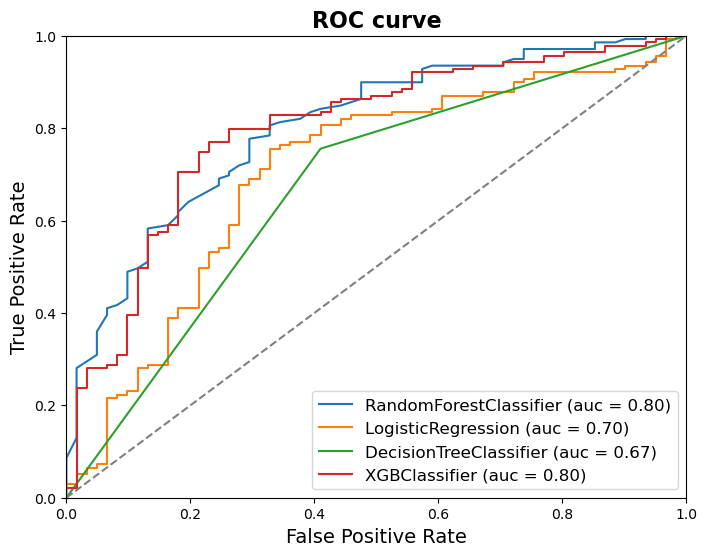

In [124]:
plot_roc_curve([rf_weight, lr_weight, dt_weight, xgb_weight], X_test, y_test)

### Reject Option based Classification (Kamiran et al. (2012))

Reject option based classification is a postprocessing technique designed by Kamiran et al. (2012) to mitigate discrimination in binary classification tasks. This approach deviates from traditional classification rules by incorporating a reject option for instances with uncertain classifications. The method introduces the concept of a critical region where the classification decision is uncertain. Instances falling within this region are relabeled to reduce discrimination : the method assigns favorable outcomes to unpriviliged groups and unfavorable outcomes to priviliged groups.

In [162]:
def reject_option_classification(clf, X_test, sens_att, theta):
    """
    Apply Reject Option-based Classification (ROC)
    
    Args:
        clf (object): A trained classifier with a predict method.
        X_test (pd.DataFrame): Test features containing the sensitive attribute.
        sens_attr (str): The name of the sensitive attribute column in X
        theta (float): Threshold for the critical region.
    
    Returns:
        np.array: Predictions after applying ROC.
    """
    y_pred = clf.predict(X_test) # Original predictions (e.g., thresholded at 0.5).
    probs = clf.predict_proba(X_test)[:,1] # Predicted probabilities for the positive class.
    roc_pred = np.copy(y_pred)
    for i, p in enumerate(probs):
        # In critical region, reassign label based on group
        if max(p, 1 - p) <= theta:
            if X_test[sens_att].reset_index(drop=True)[i] == 0:  # Unprivileged group (e.g., female)
                roc_pred[i] = 1  # Favorable outcome (e.g. good credit)
            else:  # Privileged group
                roc_pred[i] = 0  # Unfavorable outcome (e.g. bad credit)
    return roc_pred

In [163]:
def find_best_thresholds(clf, y_true, X_test, sens_att, metric_names):
    """
    Find the best threshold for Reject Option Classification for multiple fairness metrics.
    
    Parameters:
        clf: Trained classifier with `predict_proba`.
        y_true (np.array): True labels.
        X_test (np.array): Test features.
        sens_att (np.array): Sensitive attributes for the test set.
        metric_names (list): List of fairness metric names to evaluate.
        
    Returns:
        dict, list: Best thresholds for each metric and List of metrics at each threshold.
    """
    best_thetas = {metric: None for metric in metric_names}
    best_scores = {metric: -np.inf for metric in metric_names}
    metrics_list = []  # Store metrics for all thresholds
    
    for theta in np.arange(0.5, 1, 0.01):
        roc_pred = reject_option_classification(clf, X_test, sens_att, theta)
        accuracy = accuracy_score(y_true, roc_pred)
        fairness_metrics = compute_fairness_metrics(y_true, roc_pred, X_test, sens_att)
        
        # Store all metrics for this threshold
        threshold_metrics = {"theta": theta, "accuracy": accuracy}
        for metric_name in metric_names:
            threshold_metrics[metric_name] = fairness_metrics[metric_name]
            # Combine accuracy and fairness into a single score (e.g., weighted sum)
            score = accuracy - abs(fairness_metrics[metric_name])
            if score > best_scores[metric_name]:
                best_scores[metric_name] = score
                best_thetas[metric_name] = theta    
        metrics_list.append(threshold_metrics)
    
    return best_thetas, metrics_list

In [164]:
def plot_metrics_vs_thresholds(metrics_list, metric_names, best_thetas, clf_name):
    """
    Plot accuracy and multiple fairness metrics across thresholds.
    
    Args:
        metrics_list (list): List of metrics at each threshold.
        metric_names (list): List of fairness metrics to plot.
        best_thetas (dict): Best threshold for each metric.
        clf_name (str): Name of the classifier.
    """
    thresholds = [m["theta"] for m in metrics_list]
    accuracies = [m["accuracy"] for m in metrics_list]
    
    plt.figure(figsize=(10, 8))
    plt.plot(thresholds, accuracies, label="Accuracy", color="blue")
    
    # Plot each fairness metric
    colors = ["orange", "green", "red"] 
    for i, metric_name in enumerate(metric_names):
        fairness_metrics = [m[metric_name] for m in metrics_list]
        plt.plot(thresholds, fairness_metrics, label=metric_name, color=colors[i % len(colors)])
        best_theta = best_thetas[metric_name]
        plt.axvline(x=best_theta, color=colors[i % len(colors)], linestyle=":", label=f"Best threshold: θ={best_theta:.2f}")
    plt.axhline(y=0, color="grey", linestyle="--", label="Optimal fairness")
    plt.xlabel("Classification threshold (theta)")
    plt.ylabel("Accuracy and Fairness metrics")
    plt.title(f"{clf_name}", fontsize=16, fontweight="bold")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

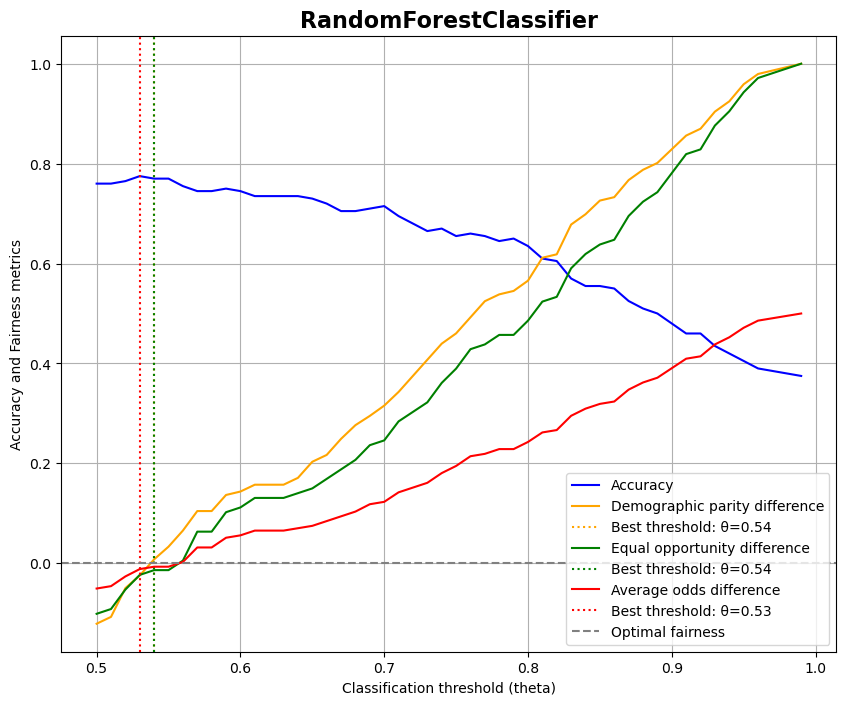

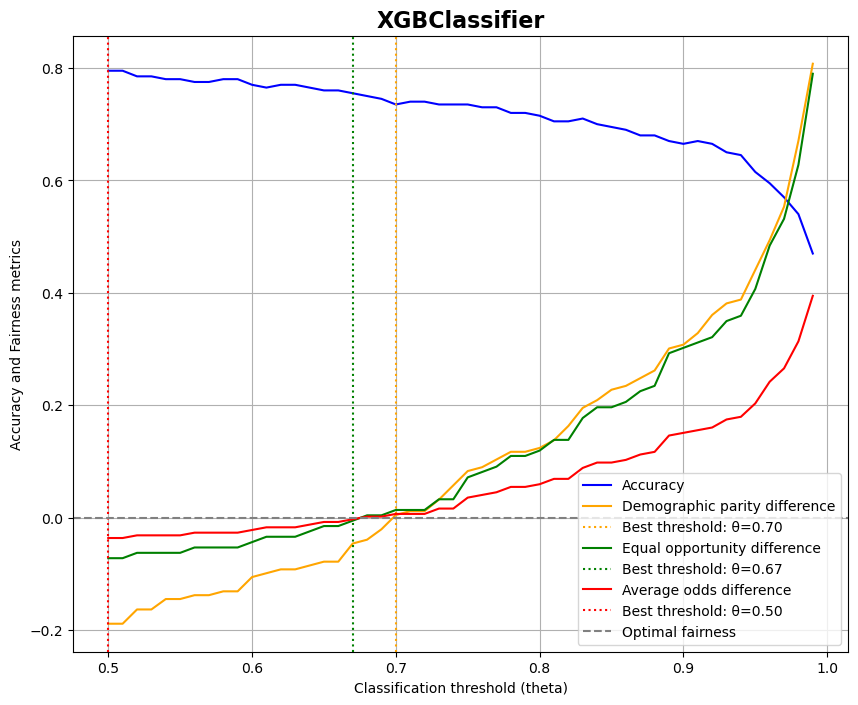

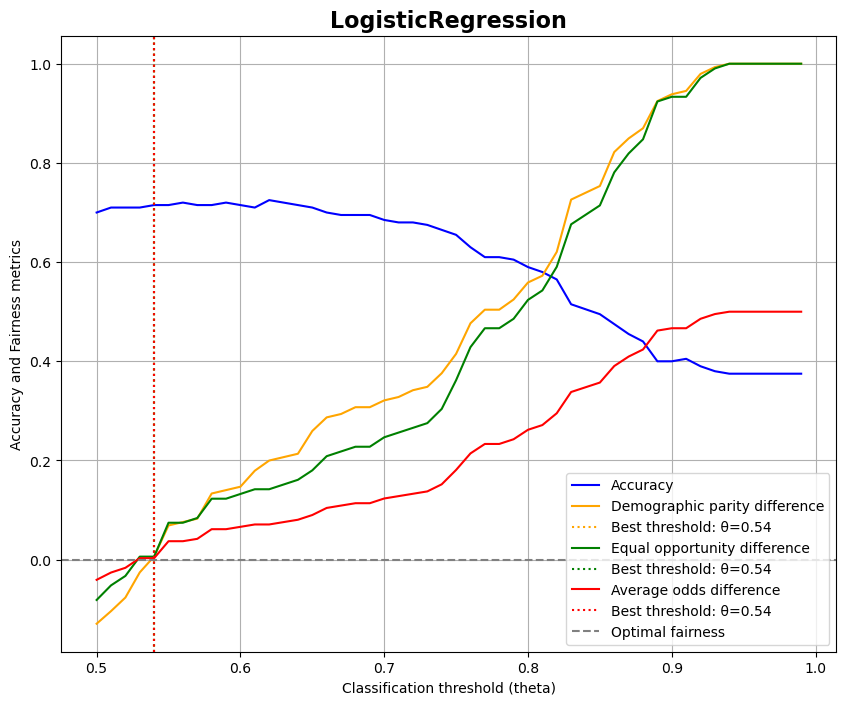

In [165]:
metric_names = [
    "Demographic parity difference",
    "Equal opportunity difference",
    "Average odds difference",
]
clfs = [rf, xgb, lr]
for clf in clfs:
    best_thetas, metrics_list = find_best_thresholds(clf, y_test, X_test, 'sex', metric_names)
    plot_metrics_vs_thresholds(metrics_list, metric_names, best_thetas, clf.__class__.__name__)

In [171]:
for clf in [rf, xgb, lr]:
    best_thetas, _ = find_best_thresholds(clf, y_test, X_test, 'sex', metric_names)
    print(f'======== {clf.__class__.__name__} ========\n')
    for metric_name, theta in best_thetas.items():
        print(f"Optimizing {metric_name} :")
        print(f"Classification threshold : {theta}")
        roc_pred = reject_option_classification(clf, X_test, 'sex', theta)
        print("Accuracy:", accuracy_score(y_test, roc_pred))
        print("Balanced accuracy:", balanced_accuracy_score(y_test, roc_pred))
        fair_metrics = compute_fairness_metrics(y_test, roc_pred, X_test, 'sex')
        for k, v in fair_metrics.items():
            print(f"{k}: {v}")
        print('\n')

======== RandomForestClassifier ========

Optimizing Demographic parity difference :
Classification threshold : 0.54
Accuracy: 0.77
Balanced accuracy: 0.7103432008491567
Demographic parity difference: 0.007864028411973534
Equal opportunity difference: -0.013725490196078494
Average odds difference: -0.006862745098039247


Optimizing Equal opportunity difference :
Classification threshold : 0.54
Accuracy: 0.77
Balanced accuracy: 0.7103432008491567
Demographic parity difference: 0.007864028411973534
Equal opportunity difference: -0.013725490196078494
Average odds difference: -0.006862745098039247


Optimizing Average odds difference :
Classification threshold : 0.53
Accuracy: 0.775
Balanced accuracy: 0.7139403231513151
Demographic parity difference: -0.0243531202435312
Equal opportunity difference: -0.023249299719887984
Average odds difference: -0.011624649859943992


======== XGBClassifier ========

Optimizing Demographic parity difference :
Classification threshold : 0.7000000000000002
